<<PCA>>
features (before PCA): 1850
features (after PCA): 135 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False) 

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        28
           1       0.83      0.87      0.85        63
           2       0.94      0.62      0.75        24
           3       0.71      0.97      0.82       132
           4       1.00      0.70      0.82        20
           5       1.00      0.36      0.53        22
           6       0.96      0.73      0.83        33

    accuracy                           0.80       322
   macro avg       0.92      0.67      0.74       322
weighted avg       0.84      0.80      0.78       322

training time: 12 seconds and 554.3 milliseconds

best parameters:
{'C': 100.0, 'class_weight': 'balanced', 

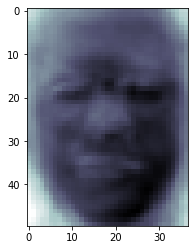

In [2]:
# install humanfriendly if necessary
!pip install humanfriendly

import numpy as np, humanfriendly as hf
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,\
     GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def see_time(note):
    end = time.perf_counter()
    elapsed = end - start
    print (note,
           hf.format_timespan(elapsed, detailed=True))

def get_cross(model, data, target, groups=10):
    return cross_val_score(model, data, target, cv=groups)

if __name__ == "__main__":
    br = '\n'
    X = np.load('data/X_faces.npy')
    y = np.load('data/y_faces.npy')
    images = np.load('data/faces_images.npy')
    targets = np.load('data/faces_targets.npy')
    _, h, w = images.shape
    n_images, n_features, n_classes = X.shape[0], X.shape[1],\
                                      len(targets)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
    pca = PCA(n_components=0.95, whiten=True, random_state=0)
    pca.fit(X_train)
    components = pca.n_components_
    eigenfaces = pca.components_.reshape((components, h, w))
    X_train_pca = pca.transform(X_train)
    pca_name = pca.__class__.__name__
    print ('<<' + pca_name + '>>')
    print ('features (before PCA):', n_features)
    print ('features (after PCA):', components, br)
    X_i = np.array(eigenfaces[0].reshape(h, w))
    fig = plt.figure('eigenface')
    ax = fig.subplots()
    image = ax.imshow(X_i, cmap='bone')
    svm = SVC(random_state=0, gamma='scale')
    print (svm, br)
    svm.fit(X_train_pca, y_train)
    X_test_pca = pca.transform(X_test)
    y_pred = svm.predict(X_test_pca)
    cr = classification_report(y_test, y_pred)
    print (cr)
    svm_name = svm.__class__.__name__    
    param_grid = {'C': [1e2, 1e3, 5e3],
                  'gamma': [0.001, 0.005, 0.01, 0.1],
                  'kernel': ['rbf'],
                  'class_weight': ['balanced']}
    grid = GridSearchCV(svm, param_grid, cv=5)
    start = time.perf_counter()
    grid.fit(X_train_pca, y_train)
    see_time('training time:')
    print ()
    bp = grid.best_params_
    print ('best parameters:')
    print (bp, br)
    svm = SVC(**bp)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    print ()
    cr = classification_report(y_test, y_pred)
    print (cr, br)
    print ('cross-validation:')
    scores = get_cross(svm, X_train_pca, y_train)
    print (np.mean(scores), br)
    file = 'data/bp_face'
    np.save(file, bp)
    # need allow_pickle=True parameter
    bp = np.load('data/bp_face.npy', allow_pickle=True)
    bp = bp.tolist()
    print ('best parameters:')
    print (bp)
    plt.show()